In [1]:
%gui qt5
import numpy as np
from skimage import io
from starfish import Experiment, display, Codebook, ExpressionMatrix, IntensityTable
from starfish.core.segmentation_mask import SegmentationMaskCollection
from starfish.image import Filter
from starfish.spots import DetectSpots, AssignTargets
from starfish.types import Axes, Coordinates, Features, FunctionSource

In [2]:
# Load the data
exp = Experiment.from_json("./output/experiment.json")
im = exp.fov().get_image('primary')

In [3]:
# View the image stack
display(im)

100%|██████████| 21/21 [00:08<00:00,  2.61it/s]


In [3]:
# Filter the image
ghp = Filter.GaussianHighPass(sigma=3)
high_passed = ghp.run(im, verbose=True, in_place=False)


glp = Filter.GaussianLowPass(sigma=1)
low_passed = glp.run(high_passed, in_place=False, verbose=True)

100%|██████████| 21/21 [00:00<00:00, 1088.66it/s]


In [4]:
# Max intensity project the spots spots image
mproj = Filter.Reduce((Axes.ZPLANE,), func='max', module=FunctionSource.np)
mip = mproj.run(low_passed)

In [15]:
# Find the spots
p = DetectSpots.BlobDetector(
    min_sigma=1,
    max_sigma=10,
    num_sigma=10,
    threshold=0.00001,
    measurement_type='mean',
)

# blobs = dots; define the spots in the dots image, but then find them again in the stack.
intensities = p.run(mip)

In [16]:
display(low_passed, intensities)

In [5]:
from InSituToolkit.analysis import save_stack

# Save the nuclei stack
nuc = exp.fov().get_image('nuclei')

nuc_mip = mproj.run(nuc)

save_stack(nuc, './nuc.tif')



100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


In [23]:
# Load the codebook and assign the genes to the spots
codebook = Codebook.open_json('codebook.json')
decoded = codebook.decode_per_round_max(intensities)

# Save the assigned spot calls
decoded.to_netcdf('assigned_spots')

In [3]:
# Load assigned spot calls
#decoded = IntensityTable.open_netcdf('assigned_spots')

In [4]:
# Get the spots corresponding with each target
Cyp2e1 = decoded.where(decoded.target == 'Cyp2e1', drop=True)
Cyp2f2 = decoded.where(decoded.target == 'Cyp2f2', drop=True)

In [5]:
# Get the cell masks
label_image = io.imread('M169_Cyp2e1C2_Cyp2f2C3_BcatC5_20xa_DC_EDF_Multifocus Image_ch03_MulticutSegmentation2.tiff')

# Get the physical ticks
yc = im.xarray.yc.values
xc = im.xarray.xc.values
physical_ticks = {Coordinates.Y: yc, Coordinates.X:xc}

# Make the mask collection
masks = SegmentationMaskCollection.from_label_image(label_image, physical_ticks=physical_ticks)

100%|██████████| 2/2 [00:00<00:00, 21.05it/s]


In [30]:
# Add a spot_id to each spot (required for assigning to cells)
decoded['spot_id'] = (Features.AXIS, np.arange(len(decoded), dtype='int32'))

# Assign the spots to cells
al = AssignTargets.Label()

labeled = al.run(masks, decoded)
cg = labeled.to_expression_matrix()
cg.save('cell_gene_matrix')

In [12]:
# Get values for plotting
Cyp2e1_counts = cg[:, 0].values
Cyp2f2_counts = cg[:, 1].values

total_counts = Cyp2e1_counts + Cyp2f2_counts

frac_Cyp2e1 = np.divide(Cyp2e1_counts, total_counts)
frac_Cyp2f2 = np.divide(Cyp2f2_counts, total_counts)

cell_x = cg.x.values
cell_y = cg.y.values

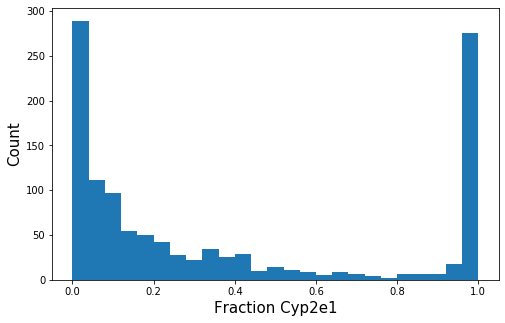

In [140]:
%matplotlib inline
from matplotlib import pyplot as plt

_, frac_ax = plt.subplots(1,1,figsize=(8, 5))
frac_ax.hist(frac_Cyp2e1, bins=25);
frac_ax.set_xlabel('Fraction Cyp2e1', fontsize=15)
frac_ax.set_ylabel('Count', fontsize=15);

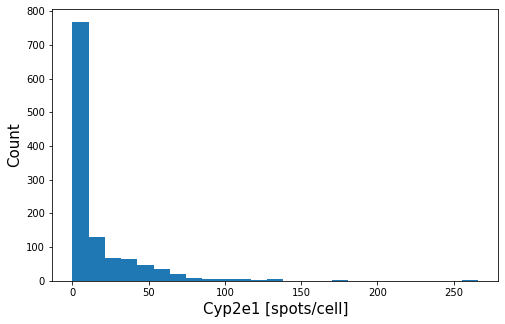

In [139]:
_, Cyp2e1_ax = plt.subplots(1,1,figsize=(8, 5))
Cyp2e1_ax.hist(Cyp2e1_counts, bins=25);
Cyp2e1_ax.set_xlabel('Cyp2e1 [spots/cell]', fontsize=15);
Cyp2e1_ax.set_ylabel('Count', fontsize=15);

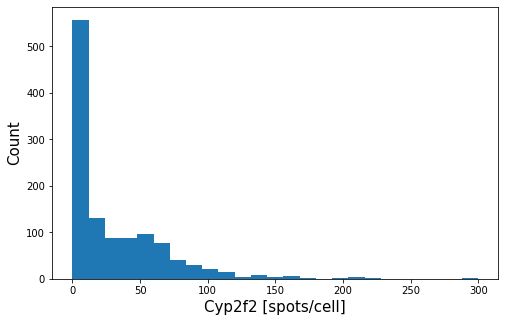

In [141]:
_, Cyp2f2_ax = plt.subplots(1,1,figsize=(8, 5))
Cyp2f2_ax.hist(Cyp2f2_counts, bins=25);
Cyp2f2_ax.set_xlabel('Cyp2f2 [spots/cell]', fontsize=15);
Cyp2f2_ax.set_ylabel('Count', fontsize=15);

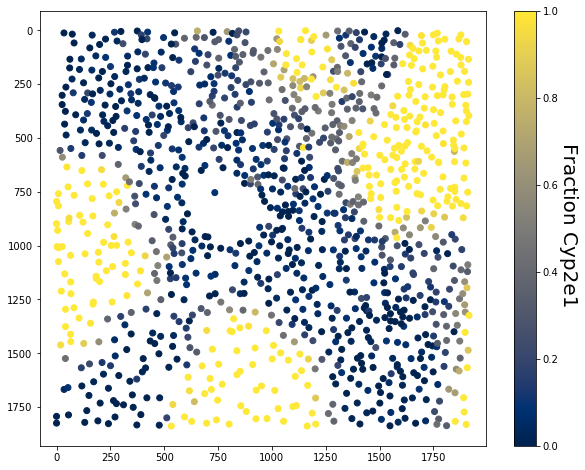

In [126]:
f, ax = plt.subplots(1,1,figsize=(10, 8)) 

points = ax.scatter(cell_x, cell_y, c=frac_Cyp2e1, cmap='cividis')

cbar = f.colorbar(points)
cbar.set_label('Fraction Cyp2e1', rotation=270, fontsize=20)
cbar.ax.get_yaxis().labelpad = 20

ax.axis('equal');
ax.invert_yaxis();

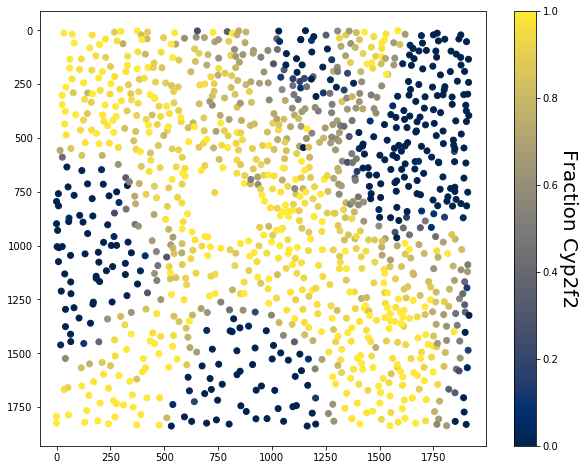

In [125]:
f2, ax2 = plt.subplots(1,1,figsize=(10, 8)) 

points = ax2.scatter(cell_x, cell_y, c=frac_Cyp2f2, cmap='cividis')

cbar2 = f2.colorbar(points)
cbar2.set_label('Fraction Cyp2f2', rotation=270, fontsize=20)
cbar2.ax.get_yaxis().labelpad = 20

ax2.axis('equal');
ax2.invert_yaxis();

In [33]:
cg = ExpressionMatrix.load('cell_gene_matrix')

In [4]:
beta_cat_image = io.imread('M169_Cyp2e1C2_Cyp2f2C3_BcatC5_20xa_DC_EDF_Multifocus Image_ch03.tif')

cell_x = cg.x.values
cell_y = cg.y.values



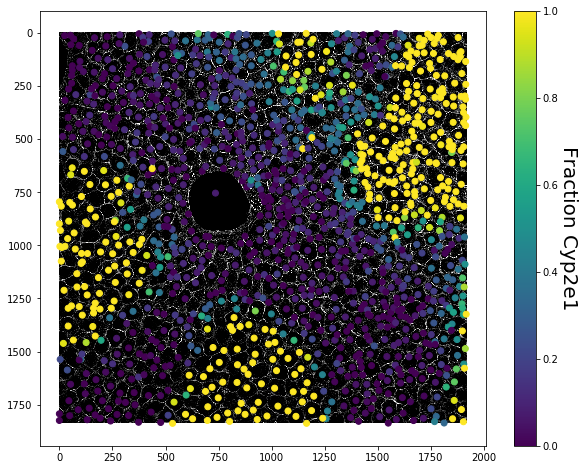

In [32]:
%matplotlib inline
from matplotlib import pyplot as plt

f3, ax3 = plt.subplots(1,1,figsize=(10, 8))
ax3.imshow(beta_cat_image, cmap='gray')
points3 = ax3.scatter(cell_x, cell_y, c=frac_Cyp2e1, cmap='viridis')
cbar3 = f3.colorbar(points3)
cbar3.set_label('Fraction Cyp2e1', rotation=270, fontsize=20)
cbar3.ax.get_yaxis().labelpad = 20
ax3.axis('equal');

plt.savefig('overlay.png', bbox_inches='tight')

In [31]:
# Get values for plotting
Cyp2e1_counts = cg2[:, 0].values
Cyp2f2_counts = cg2[:, 1].values

total_counts = Cyp2e1_counts + Cyp2f2_counts

frac_Cyp2e1 = np.divide(Cyp2e1_counts, total_counts)
frac_Cyp2f2 = np.divide(Cyp2f2_counts, total_counts)

cell_x = cg2.x.values
cell_y = cg2.y.values

In [6]:
viewer = display(spots=Cyp2e1)
viewer = display(spots=Cyp2f2, viewer=viewer, masks=masks2)


In [7]:
beta_cat_image = io.imread('M169_Cyp2e1C2_Cyp2f2C3_BcatC5_20xa_DC_EDF_Multifocus Image_ch03.tif')
viewer.add_image(beta_cat_image)

<Image layer 'Image' at 0x12fcc1390>